# Patch extraction from Histology Images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/04-patch-extraction.ipynb)

[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/04-patch-extraction.ipynb)

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

# Welcome to tiatoolbox!

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right click on "Open in Colab" and select "Open in new tab" if left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://tia-toolbox.readthedocs.io/en/develop/installation.htmle) file.

### About this demo
In this example we will show how you can use tiatoolbox to extract patches from a large histology image. Tiatoolbox can extract patches in different ways, such as point-based, fixed-window, and variable-window patch extraction. One practical use of these tools is when using deep learning models that cannot accept large images in the input. In particular, we will introduce the use of our module
`patchextraction` ([details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/tiatoolbox/tools/patchextraction.py)).

### Setting up the environment
You can skip this cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://tia-toolbox.readthedocs.io/en/develop/installation.html).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1

print('Installation is done.')

This cell removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.

In [ ]:
%%bash
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )

### Importing related libraries
We will start by importing some libraries required to run this notebook.

In [3]:
from tiatoolbox.tools import patchextraction
from tiatoolbox.utils.misc import imread
from tiatoolbox.utils.misc import read_locations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, a couple of files (a histology image and a csv file containing the positions of nuclei in that image). Download is needed once in each Colab session.

In [4]:
import requests

img_file_name = "sample_img.png"
csv_file_name = "sample_coordinates.csv"

# Downloading sample image from MoNuSeg
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/testdata/patchextraction/TCGA-HE-7130-01Z-00-DX1.png")
with open(img_file_name, "wb") as f:
    f.write(r.content)

# Downloading points list 
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/testdata/patchextraction/sample_patch_extraction.csv")
with open(csv_file_name, "wb") as f:
    f.write(r.content)

print('Download is complete.')

Download is complete.


# Reading image and annotation file
We use a sample image from the [MoNuSeg](https://monuseg.grand-challenge.org/Data/) dataset, for which nuclei have already been located (manually) and centroids computed. The sample image and list of points are loaded from the internet. The function `read_locations` returns a dataFrame, in which a typical row has the form $(x, y, class)$. Here $(x,y)$  are coordinates for a particular centroid, and *class* is the type of that patch. For this example, "class" can indicate the type of the nucleus, such as "epithelial" or "inflammatory". In the simple situation we are illustrating here, biological information has not been provided, and is replaced by a meaningless number 0.0, which is just a place-holder. Dataframes in Python are handled using `pandas`. You don't need to learn the details to understand this demo, but, if you want to use dataframes in your own code, or to replace data in this notebook by your own data, you will need to find out more about [pandas](https://pandas.pydata.org/docs/user_guide/index.html).

In [5]:
input_img = imread(img_file_name)
centroids_list = read_locations(csv_file_name) 

print('Image size: {}'.format(input_img.shape))
print('This image has {} point annotations'.format(
                                        centroids_list.shape[0]))
print('First few lines of dataframe:\n', centroids_list.head())

Image size: (1000, 1000, 3)
This image has 1860 point annotations
First few lines of dataframe:
       x     y  class
0  14.0   3.0    0.0
1   3.0  15.0    0.0
2  13.0  13.0    0.0
3  58.0   8.0    0.0
4  69.0   8.0    0.0


To see better what we are dealing with here, we show the image, first in its original form, and then with the desired centroids overlaid.

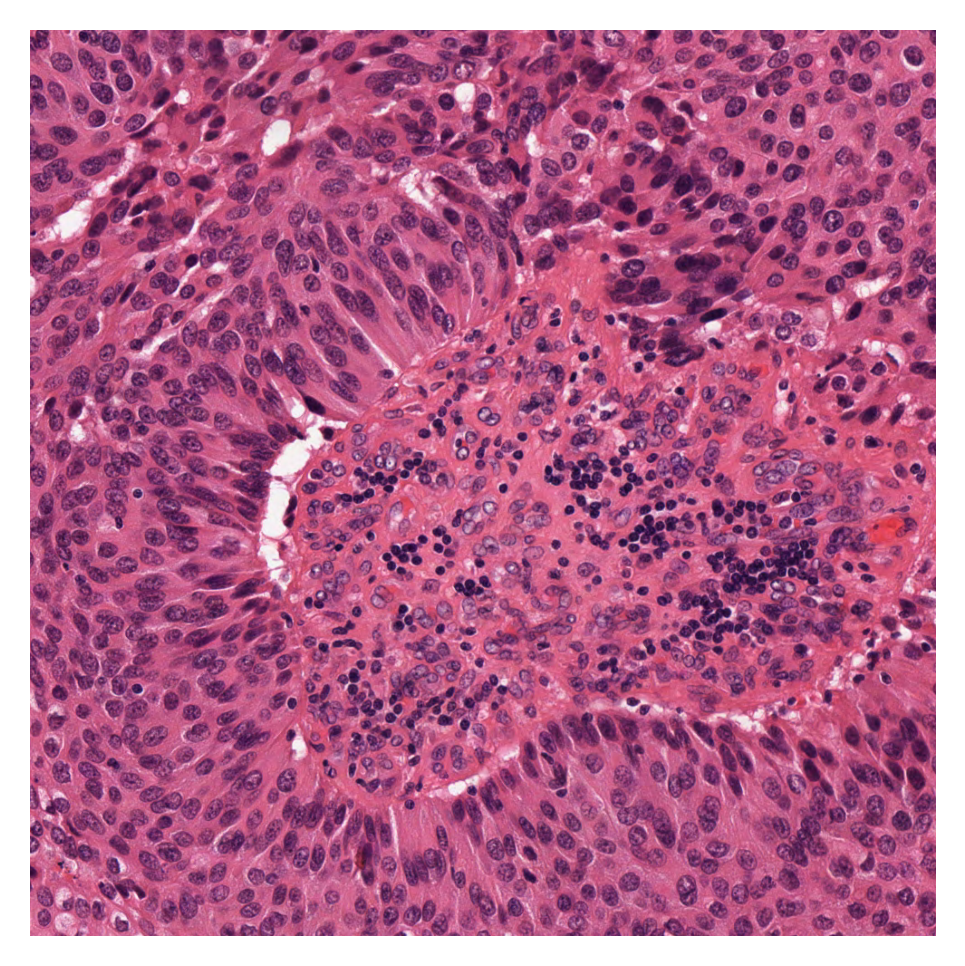

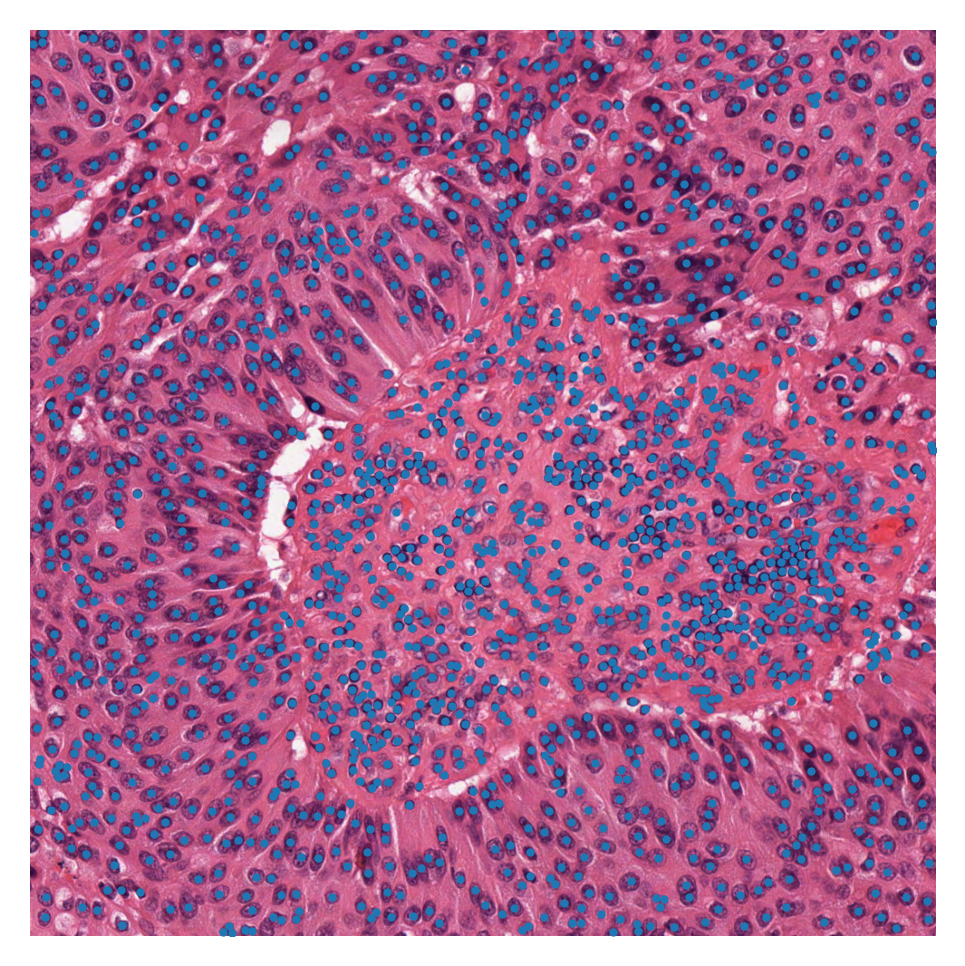

In [6]:
input_img = imread(img_file_name)
plt.imshow(input_img)
plt.axis('off')
plt.show()

# overlay nuclei centroids on image and plot
plt.imshow(input_img)
plt.scatter(np.array(centroids_list)[:,0], np.array(centroids_list)[:,1], s=1)
plt.axis('off')
plt.show()

## Patches based on point annotations
As you can see in the above figure, each nucleus is marked with a blue dot. To train a nucleus classifier computer program (or a beginning pathologist), it is helpful to see a nucleus in context, that is, within a surrounding patch. Therefore, we extract, for each nucleus, a patch centred on that nucleus. If the third column of our dataframe has been completed meaningfully (which is not the case in our example), it is then easy to save patches in different folders based on their biological significance or class=classification. This can be done using functions from the Python classes defined in our module `patchextraction` . (We are using both class=biological classification and class=Python class for coding.) The `patch_extractor` yields patches from the image, `input_img`, based on the `centroids_list` in a one-by-one manner. In the next code cell, we show how to use the function `get_patch_extractor` to obtain a suitable `patch_extractor`

In [18]:
patch_extractor = patchextraction.get_patch_extractor(
        input_img=input_img, # input image path, numpy array, or WSI object
        locations_list=np.array(centroids_list)[500:600,:], # path to list of points (csv, json), numpy list, panda DF
        method_name="point", # also supports "slidingwindow"
        patch_size=(32, 32), # size of the patch to extract around the centroids from centroids_list
        resolution=0,
        units="level",
    )

As you can see, `patchextraction.get_patch_extractor` accepts several arguments:

- `input_img`: The image from which we want to extract patches. We can read the image and pass it to the function as a numpy array or instead, you can pass the path of the image file to the function.
- `locations_list`: The list of points at which the required patches will be centred. We load the points list as a panda data frame and pass it to the function or instead, you can pass to the function the path to  a csv, npy or json file.
- `method_name`: This important argument specifies the type of patch extractor that we want to build. As we are looking to extract patches around centroid points, we use here the `point` option. Another option of `slidingwindow` is also supported. Please refer to the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html#module-tiatoolbox.tools.patchextraction) for more information.
- `patch_size`: Size of the patches. 
- `resolution` and `unit`: These arguments specify the level or micron-per-pixel resolution of the WSI. Here we specify the WSI's level 0. In general, this is the level of greatest resolution, although, in this particular case, the image has only one level. More information can be found in the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader.WSIReader.read_rect). 

The `patch_extractor` yields information in small chunks, so as to avoid potential memory problems when the list of centroids is very long.
To extract patches using the `patch_extractor` we use ***for loop***s as below, where we extract the first 16 patches specified by `centroids_list`.

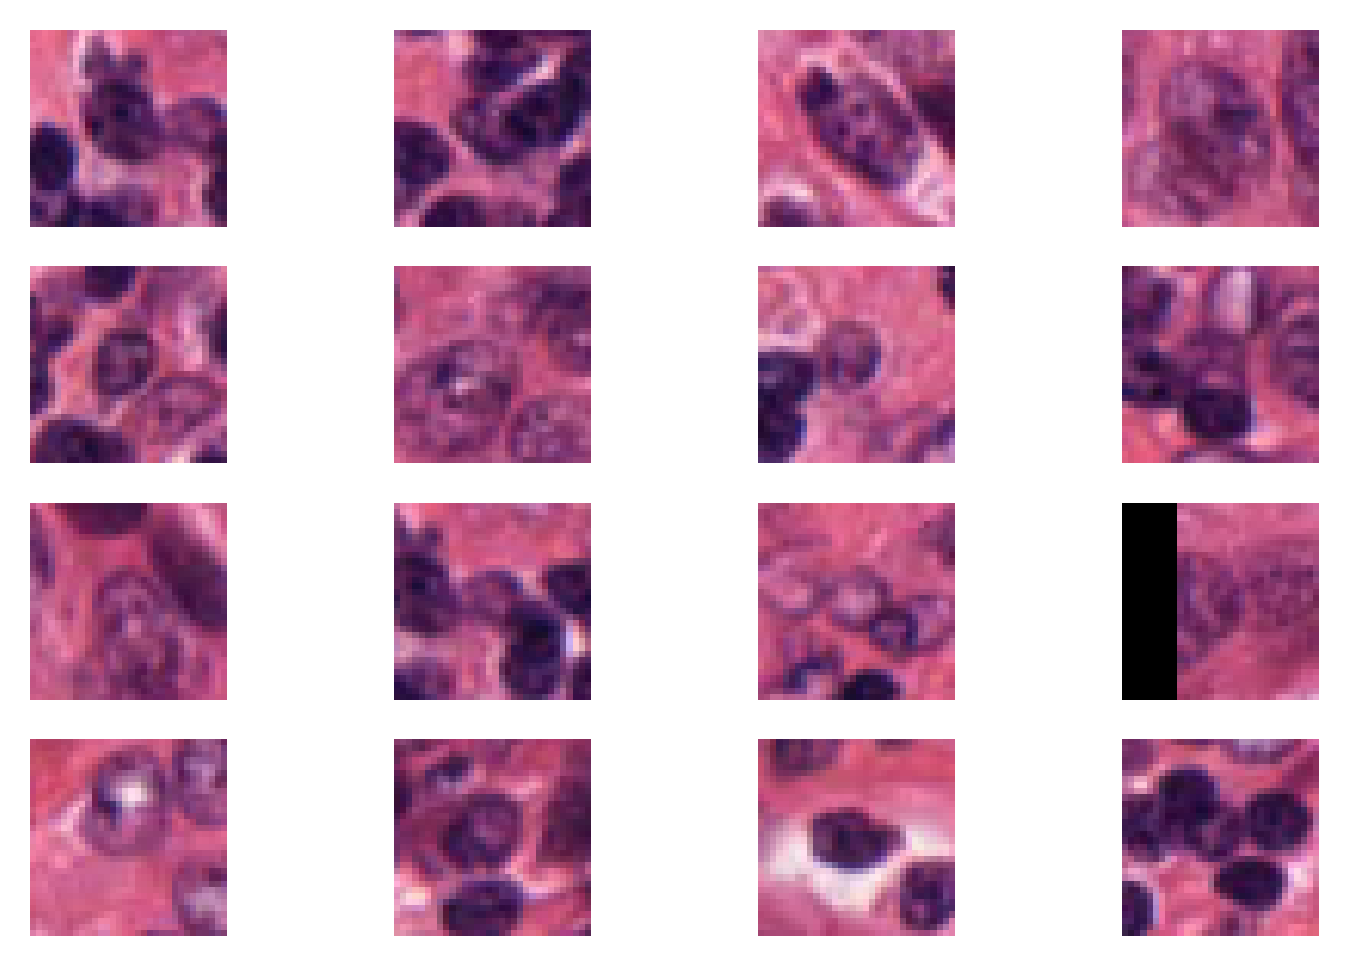

In [19]:
i = 1
for patch in patch_extractor:
    plt.subplot(4,4,i)
    plt.imshow(patch)
    plt.axis('off')
    if i >= 16: # show only first 16 patches
        break
    i += 1
plt.show()


Using the defined point `patch_extractor` we can extract a patch around a particular point in the dataFrame. For that, you just simply specify the index of the desired point for the `patch_extractor`. For example, if we want to extract the patch around the 66th point in the dataFram, we can do as below:

(-0.5, 31.5, 31.5, -0.5)

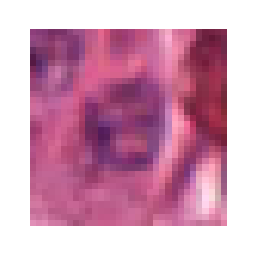

In [20]:
desired_patch = patch_extractor[66]

plt.subplot(4,4,1)
plt.imshow(desired_patch)
plt.axis('off')


# Generate fixed-size patches
A very common practice in computational pathology, when analyzing large histology images or WSIs, is to extract overlapping patches from that image and analyse them one by one. Deep Learning models often cannot accept large images due to memory limitations. We designed a tool in Tiatoolbox to ease the process of overlapping patch extraction for such goals. 

The same `patchextraction` class supports another method that allows the user to extract all the patches from the input image in an efficient way, using just one line of code. In order to do that, one changes the method name in the `patchextraction` to `"slidingwindow"` as below: 


In [21]:
fixed_patch_extractor = patchextraction.get_patch_extractor(
        input_img=input_img, # input image path, numpy array, or WSI object
        method_name="slidingwindow", # also supports "point" and "slidingwindow"
        patch_size=(500, 500), # size of the patch to extract around the centroids from centroids_list
        stride=(500, 500) # stride of extracting patches, default is equal to patch_size
    )

The `patchextraction` splits the input image into patches of size 500x500 without any overlap, because the `stride` of patch extraction is the same as `patch_size`. The `fixed_patch_extractor` is an iterator that yields a patch each time it is called. As in the example above, we can use a **for** loop to access these patches:

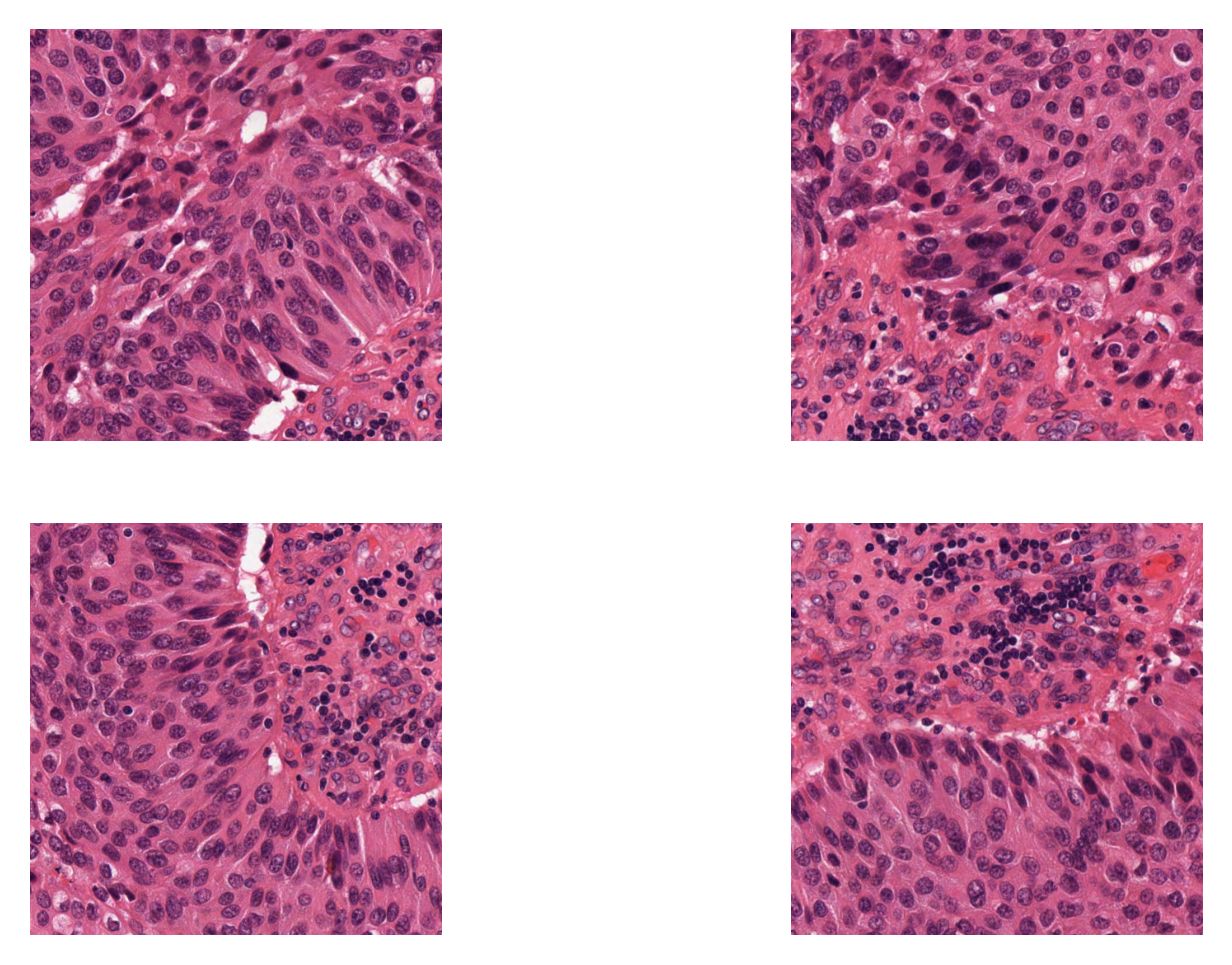

In [22]:
i = 1
for patch in fixed_patch_extractor:
    plt.subplot(2,2,i)
    plt.imshow(patch)
    plt.axis('off')
    i += 1
plt.show()

Otherwise, by setting the `stride` smaller than the 'patch_size`, we can extract overlapping patches. Below we extract 500x500 patches that have 250 pixels overlap in both axes. 

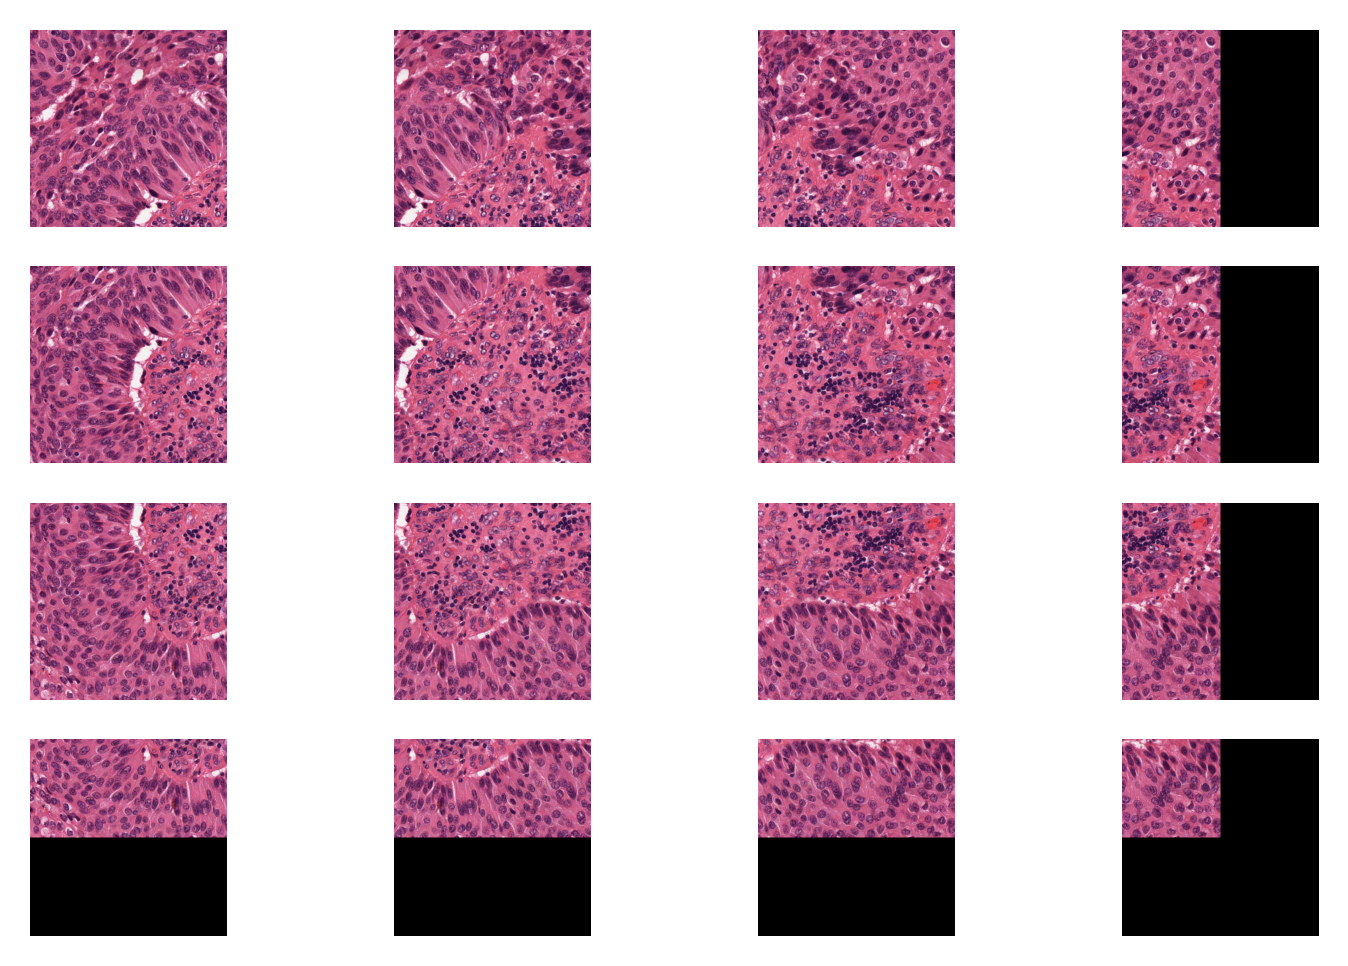

In [27]:
fixed_patch_extractor = patchextraction.get_patch_extractor(
        input_img=input_img, # input image path, numpy array, or WSI object
        method_name="slidingwindow", # also supports "point" and "slidingwindow"
        patch_size=(500, 500), # size of the patch to extract around the centroids from centroids_list
        stride=(250, 250) # 250 pixels overlap in both axes
    )

i = 1
for patch in fixed_patch_extractor:
    plt.subplot(4,4,i)
    plt.imshow(patch)
    plt.axis('off')
    i += 1
plt.show()

Remember, you can always access a specific patch in your patch extractor using its index, as below:

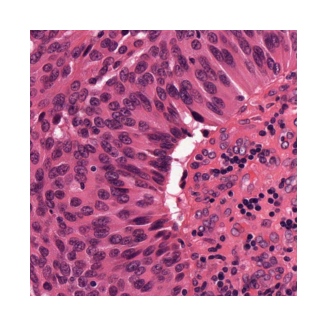

In [28]:
patch_idx = 4 # setting the patch index to point the fifth (middle) patch
this_path = fixed_patch_extractor[patch_idx] # extracting the desired patch

#displaying the patch
plt.subplot(3,3,1)
plt.imshow(this_path)
plt.axis('off')
plt.show()

As you can see, the extracted patch is the same as the middle one in the above example.